# Paquetes

In [ ]:
# !pip install sciann --quiet

     |████████████████████████████████| 172 kB 8.5 MB/s 
     |████████████████████████████████| 561 kB 13.8 MB/s 


In [ ]:
# !pip install mlflow --quiet

     |████████████████████████████████| 14.4 MB 63 kB/s 
     |████████████████████████████████| 636 kB 55.0 MB/s 
     |████████████████████████████████| 146 kB 73.6 MB/s 
     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 170 kB 61.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.1 MB/s 
     |████████████████████████████████| 75 kB 5.6 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os

# os.chdir('/content/drive/MyDrive/Colab Notebooks/TFM/Experimento Placa')

In [1]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath
import tensorflow as tf 

#MlFlow
import mlflow
from mlflow import log_metric, log_param

import pickle

from itertools import product

import time

%load_ext autotime

---------------------- SCIANN 0.6.4.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.3.0 
Python Version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)] 

time: 0 ns (started: 2021-08-26 18:25:15 +02:00)


#  Preprocesamiento de datos

## Modelo numérico

In [2]:
def lee_u(u_file):
    values = []
    times = []
    fd = open(u_file,'r')
    for tupla in fd.read().split('\n\n'):
        if tupla != '':
            tiempo, datos = tupla.split('\n')
            times.append(float(tiempo))
            vector = []
            for value in datos.split('\t'):
                    if value != '':
                        vector.append(float(value))
            values.append(vector)
    values = np.array(values)
    fd.close()
    return times, values

def lee_mesh(mesh_file):
    fd = open(mesh_file)
    for batch in fd.read().split('\n\n'):
        if batch[0:8]=='Vertices':
            vertices = batch
    fd.close()

    coordenadas = []

    for vertice in vertices.split('\n'):
        if len(vertice.split(' ')) == 3:
            coordenadas.append([float(vertice.split(' ')[0]),float(vertice.split(' ')[1])])
    coordenadas = np.array(coordenadas)
    return coordenadas

def preparadatos(u_file,mesh_file):
    datos = lee_u(u_file)
    mesh = lee_mesh(mesh_file)
    
    sec = datos[0][0]
    fullmesh = np.insert(mesh,2,sec,axis=1)
    
    for i in range(1,len(datos[0])):
        sec = datos[0][i]
        fullmesh = np.append(fullmesh,np.insert(mesh,2,sec,axis=1),axis=0)
    
    valores = datos[1].flatten()
    
    return fullmesh,valores

from scipy.interpolate import griddata

time: 0 ns (started: 2021-08-26 18:25:15 +02:00)


## Mallado del test (estático)



In [7]:
denspt = 12 # Densidad de puntos de evaluación de los funcionales
xmin,xmax=-2,2 # Límites en x
ymin,ymax =-2,2 # Límites en y
tmin,tmax=0,10 # Límites en tiempo t
xrange=xmax-xmin
yrange=ymax-ymin
trange=tmax-tmin

xx = np.linspace(xmin, xmax, xrange*denspt) 
yy = np.linspace(ymin, ymax, yrange*denspt)
tt = np.linspace(tmin, tmax, trange*denspt)

grid = np.meshgrid(xx,yy,tt)

x_test, y_test, t_test = grid

time: 0 ns (started: 2021-08-26 18:25:32 +02:00)


In [8]:
np.product(x_test.shape)

276480

time: 0 ns (started: 2021-08-26 18:25:33 +02:00)


In [9]:
#Archivos de datos
u_file = 'u.txt'
mesh_file = 'ofen'
#Predicciones del numérico
puntos, valores = preparadatos(u_file,mesh_file)
print('Datos preparados')
u_pred_Num = griddata(puntos, valores, (x_test, y_test, t_test) , method='nearest')

Datos preparados
time: 22.2 s (started: 2021-08-26 18:25:37 +02:00)


## Wrappers en forma de funciones


In [10]:
# Activación para los bordes

def activacion(coord,location,direction):
    return (1-sign(direction*(location-coord)))/2



time: 0 ns (started: 2021-08-26 18:25:59 +02:00)


## Constantes del problema

In [11]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 1. # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = 1. # Capacidad conductora de calor del material de la placa
capCal = 1. # Capacidad de retención de calor del material de la placa
focoTemp = 10. # Temperatura del foco de calor
tempExt = 5. # Temperatura del exterior
tempInicial = 0. # Temperatura inicial de la placa
sigma = 0.4 #Amplitud del foco de calor

time: 0 ns (started: 2021-08-26 18:25:59 +02:00)


# Mallado de parámetros de experimentación

In [16]:
trainpt = [5]
u_Structure = [4*[200]]
u_Activator = ['tanh']
epochs = [1000]
loss = ['mae']
optimizer = ['Adam']
batch_size = [20000]



configuraciones = list(product(trainpt,u_Structure,u_Activator,epochs,loss,optimizer,batch_size))
configuraciones = [list(configuracion) for configuracion in configuraciones]
configuraciones_finalizadas = list([])

print(len(configuraciones))

1
time: 16 ms (started: 2021-08-26 18:28:22 +02:00)


In [17]:
# configuraciones_finalizadas = configuraciones
np.save('configuraciones_finalizadas',configuraciones_finalizadas,allow_pickle=True)

time: 0 ns (started: 2021-08-26 18:28:23 +02:00)


In [18]:
configuraciones_finalizadas = np.load('configuraciones_finalizadas.npy',allow_pickle=True).tolist()
configuraciones_restantes = [configuracion for configuracion in configuraciones if configuracion not in configuraciones_finalizadas]
print(len(configuraciones_restantes))

1
time: 15 ms (started: 2021-08-26 18:28:23 +02:00)


# Loop

In [19]:
# resultados  = []
for configuracion in configuraciones_restantes:
    with mlflow.start_run():
        
        print('Experimentando con:' + str(configuracion))
        
        #Parámetros
        #################
        trainpt = configuracion[0]
        u_Structure = configuracion[1]
        u_Activator = configuracion[2]
        epochs = configuracion[3]
        loss = configuracion[4]
        optimizer = configuracion[5]
        batch_size = configuracion[6]
        #################

        #Log de parámetros
        #################
        mlflow.log_param('Density', trainpt)
        mlflow.log_param('u_Structure', u_Structure)
        mlflow.log_param('u_Activator', u_Activator)
        mlflow.log_param('Epochs', epochs)
        mlflow.log_param('Loss', loss)
        mlflow.log_param('Optimizer', optimizer)
        mlflow.log_param('Batch size', batch_size)
        #################
        #Variables del modelo
        #################
        x = sn.Variable("x") 
        y = sn.Variable('y')
        t = sn.Variable('t')
        u = sn.Functional("u", [x,y,t], u_Structure ,u_Activator)
        #################
    
        #Construcción del mallado
        #################
        

        # Mallado (es una malla en tres dimensiones)
        denspt = trainpt # Densidad de puntos de evaluación de los funcionales
        xmin,ymin,xmax,ymax=-2,-2,2,2 # Límites en x e y
        tmin,tmax=0,10 # Límites en tiempo t
        xrange,yrange=xmax-xmin,ymax-ymin
        trange=tmax-tmin

        # Mallado (es una malla en tres dimensiones)
        x_data, y_data, t_data = np.meshgrid(
            np.linspace(xmin, xmax, xrange*denspt), 
            np.linspace(ymin, ymax, yrange*denspt),
            np.linspace(tmin,tmax,trange*denspt)
        )

        x_data = x_data.flatten()[:,None]
        y_data = y_data.flatten()[:,None]
        t_data = t_data.flatten()[:,None]

        numpoints =  trainpt**3*xrange*yrange*trange
        
        mlflow.log_param('Num_Points', numpoints)
        #################

        #Restricciones
        #################
        
        #Aislamiento en los bordes x=-2 y x=2
        L2 = conveccion * diff(u,x)
        d2 = sn.constraints.Data(L2)
        #Indices de los bordes
        indAislamiento = np.where(np.abs(x_data)+TOL>2)[0][:,None]
        datos2 = [(indAislamiento,'zeros')]
        
        #Temperatura constante en los bordes y=-2 e y=2
        indConveccion = np.where(np.abs(y_data)+TOL > 2)[0][:,None]
        d3 = sn.constraints.Data(u)
        datos3 = [(indConveccion,tempExt)]
        
        #Temperatura inicial
        indInicial = np.where(t_data < TOL)[0][:,None]
        valInicial = tempExt/2 * np.abs(y_data[indInicial,0])
        d4 = sn.constraints.Data(u)
        datos4 = [(indInicial,valInicial)]
  
        #Temperatura foco
        radio = np.sqrt(x_data[:,0]**2+y_data[:,0]**2)
        indCentro = np.where(radio<sigma)[0]
        indT_desde_05 = np.where(t_data[:,0]>5)[0]
        indCentro_desde_05 = np.intersect1d(indCentro,indT_desde_05)[:,None]
        valCentro = 5 + 5 *  np.exp(-(x_data[indCentro_desde_05,0]**2+y_data[indCentro_desde_05,0]**2)/(2*(sigma)**2))/np.sqrt((2*np.pi*sigma**2))*(1/(1+np.exp(-4*(t_data[indCentro_desde_05,0]-6))))
#         d5 = sn.constraints.Data(u)
#         datos5 = [(indCentro_desde_05,valCentro)]

        flux_T = capCal*diff(u,t)
        flux_XY = conductividad *( diff(u,x,order=2) + diff(u,y,order=2))

        d5 = sn.constraints.Tie(flux_T,flux_XY)
        datos5 = [(indCentro_desde_05,valCentro)]

        #Este funcional explica el flujo del calor a lo largo de la placa (2 dimensiones)

        ecCalor = capCal*diff(u,t) - conductividad *( diff(u,x,order=2) + diff(u,y,order=2))
        L1 = sn.constraints.PDE(ecCalor)
        fullset = np.arange(numpoints)[:,None]
        indSinFoco = np.setdiff1d(fullset,indCentro_desde_05,assume_unique=True)
        indSinFoco = np.setdiff1d(indSinFoco,indConveccion)

        datos1 = [(indSinFoco,'zeros')]
 
        #Agregamos restricciones
        datos = datos1+datos2+datos3+datos4+datos5

        #################
        #Construcción del modelo
        m = sn.SciModel ([x,y,t], [L1,d2,d3,d4,d5], loss,optimizer)

        #Entrenamiento del modelo
        start = time.process_time()
        history = m.train([x_data, y_data, t_data], datos, epochs =epochs,verbose=0,
                        batch_size=batch_size)
        TEntrenamiento = time.process_time() - start

        #Testeo del modelo:

        start2 = time.process_time()
        u_pred_sciann =  u.eval(m, [x_test, y_test, t_test])
        TTesteo = time.process_time() - start2

        MAE = np.mean(np.abs(u_pred_Num-u_pred_sciann))*160
        RMSE = np.sqrt(np.mean((u_pred_Num-u_pred_sciann)**2))*160

        pred = m.model.predict([np.reshape(x_test,(-1,)),np.reshape(y_test,(-1,)),np.reshape(t_test,(-1,))])

        funcional = np.mean(np.abs(np.array(pred[1])))
        
        MAX = np.max(np.abs(u_pred_Num-u_pred_sciann))
        
        mlflow.log_metric('L1',MAE)
        mlflow.log_metric('L2',RMSE)
        mlflow.log_metric('MaxError',MAX)
        mlflow.log_metric('Funcional',funcional)
        mlflow.log_metric('Tiempo_Entrenamiento',TEntrenamiento)
        mlflow.log_metric('Tiempo_Evaluacion',TTesteo)
        
        np.save('Predicciones',u_pred_sciann,allow_pickle=True)
        mlflow.log_artifact('Predicciones.npy')
        
        np.save('Historial',history.history,allow_pickle=True)
        mlflow.log_artifact('Historial.npy')
        
        configuraciones_finalizadas.append(configuracion)
        np.save('configuraciones_finalizadas',configuraciones_finalizadas)

2021/08/26 18:28:37 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Experimentando con:[5, [200, 200, 200, 200], 'tanh', 1000, 'mae', 'Adam', 20000]

Total samples: 20000 
Batch size: 20000 
Total batches: 1 

time: 6min 48s (started: 2021-08-26 18:28:37 +02:00)


In [15]:
datos

[(array([ 1000,  1001,  1002, ..., 18997, 18998, 18999]), 'zeros'),
 (array([[    0],
         [    1],
         [    2],
         ...,
         [19997],
         [19998],
         [19999]], dtype=int64),
  'zeros'),
 (array([[    0],
         [    1],
         [    2],
         ...,
         [19997],
         [19998],
         [19999]], dtype=int64),
  5.0),
 (array([[    0],
         [   50],
         [  100],
         [  150],
         [  200],
         [  250],
         [  300],
         [  350],
         [  400],
         [  450],
         [  500],
         [  550],
         [  600],
         [  650],
         [  700],
         [  750],
         [  800],
         [  850],
         [  900],
         [  950],
         [ 1000],
         [ 1050],
         [ 1100],
         [ 1150],
         [ 1200],
         [ 1250],
         [ 1300],
         [ 1350],
         [ 1400],
         [ 1450],
         [ 1500],
         [ 1550],
         [ 1600],
         [ 1650],
         [ 1700],
        

time: 47 ms (started: 2021-08-18 19:56:42 +02:00)


In [138]:
np.save('Historial',history.history,allow_pickle=True)

mlflow.log_artifact('Historial.npy')

time: 31 ms (started: 2021-08-15 18:04:06 +02:00)


In [109]:
valCentro.max()

9.30623961530893

time: 0 ns (started: 2021-08-15 17:40:29 +02:00)


In [20]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

time: 0 ns (started: 2021-08-26 18:35:25 +02:00)


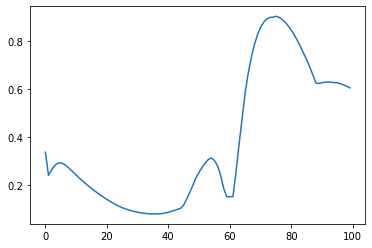

time: 125 ms (started: 2021-08-15 17:40:29 +02:00)


In [113]:
plt.plot(np.max(np.abs(u_pred_Num-u_pred_sciann),axis=(0,1)))

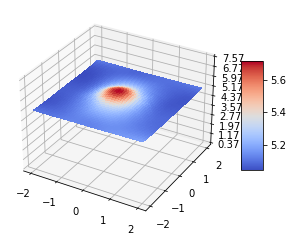

time: 422 ms (started: 2021-08-26 18:36:34 +02:00)


In [26]:
tiempoMostrado = 5 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

# map = np.abs(u_pred_sciann-u_pred_Num)

X = x_test[:,:,0]
Y = y_test[:,:,0]
Z = u_pred_sciann[:,:,round((tiempoMostrado-tmin)*12)]


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
ax.set_zlim(u_pred_sciann.min(), u_pred_sciann.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
fig.savefig('SIM_PINN.png')

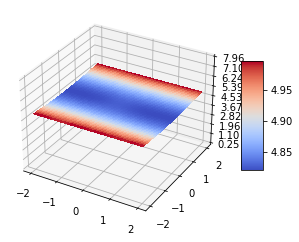

time: 438 ms (started: 2021-08-26 18:36:44 +02:00)


In [27]:
tiempoMostrado =  5 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

map = np.abs(u_pred_sciann-u_pred_Num)

X = x_test[:,:,0]
Y = y_test[:,:,0]
Z = u_pred_Num[:,:,round((tiempoMostrado-tmin)*12)]


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
ax.set_zlim(u_pred_Num.min(), u_pred_Num.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
fig.savefig('SIM_NUM.png')